<img src="https://s2.loli.net/2024/01/15/xhXQeOgG6ctWrHL.png"/>

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tqdm

[0.5]


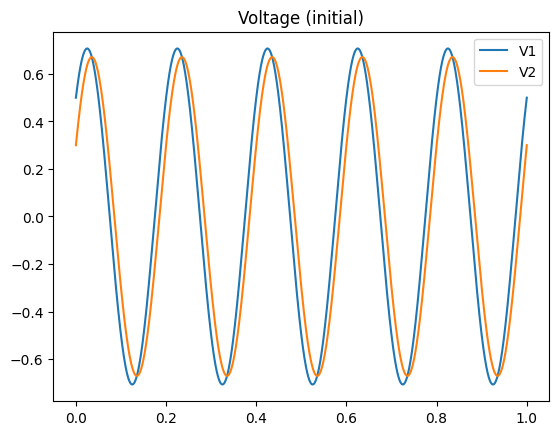

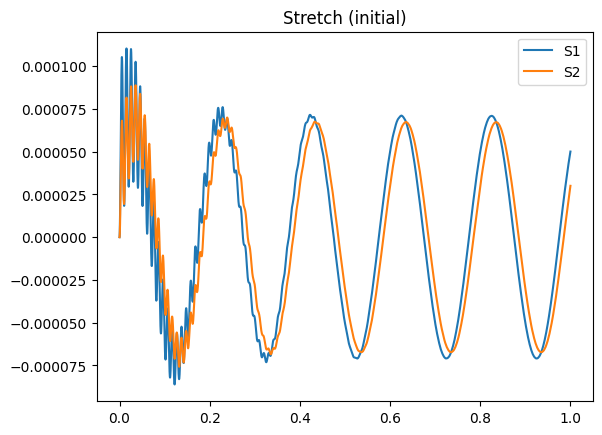

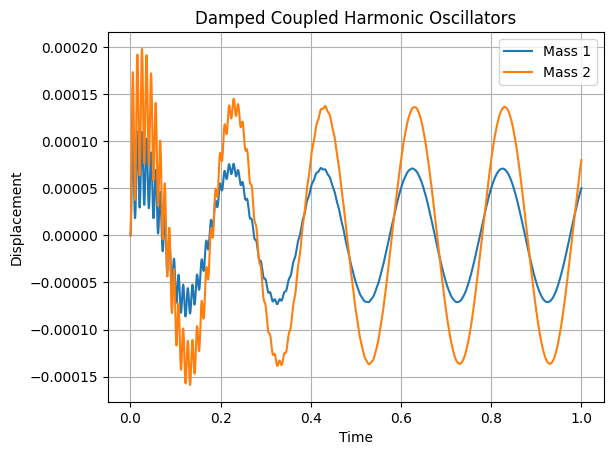

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
#
Gamma = 1E0
Cap = 1E-7
# Define the system of ODEs for damped coupled oscillators
def damped_coupled_oscillators(t, y, k1, k2, b1, b2, m1, m2, vol1, vol2, freq):
    x1, v1, x2, v2 = y
    f1 = (vol1[0] @ np.sin(2 * np.pi * t * freq) + vol2[0] @ np.cos(2 * np.pi * t * freq)) * Gamma
    f2 = (vol1[1] @ np.sin(2 * np.pi * t * freq) + vol2[1] @ np.cos(2 * np.pi * t * freq)) * Gamma
    dx1dt = v1
    dv1dt = (-k1 * x1 - b1 * v1 + k2 * (x2 - x1) - b2 * (v1 - v2) + f1 - f2) / m1
    dx2dt = v2
    dv2dt = (-k2 * (x2 - x1) - b2 * (v2 - v1) + f2) / m2
    return [dx1dt, dv1dt, dx2dt, dv2dt]

# System parameters
m1, m2 = 1.0E-2, 1.0E-2  # Masses
k1, k2 = 1E4, 1E4  # Spring constants
b1, b2 = 0.5, 0.5  # Damping coefficients

# Initial conditions
x1_initial = 0.0  # Initial displacement of mass 1
v1_initial = 0.0  # Initial velocity of mass 1
x2_initial = 0.0  # Initial displacement of mass 2
v2_initial = 0.0  # Initial velocity of mass 2
initial_conditions = [x1_initial, v1_initial, x2_initial, v2_initial]

# Time span for the simulation
t_span = (0, 1)  # Start and end times
t_eval = np.linspace(t_span[0], t_span[1], 5000)  # Time points at which to store the computed solutions

# 
freq = np.array([5])
vol1 = np.array([[.5], [.6]])
vol2 = np.array([[.5], [.3]])
print(vol1[0])
#
V1, V2 = [], []
for t in t_eval:
    V1.append(vol1[0] @ np.sin(2 * np.pi * t * freq) + vol2[0] @ np.cos(2 * np.pi * t * freq))
    V2.append(vol1[1] @ np.sin(2 * np.pi * t * freq) + vol2[1] @ np.cos(2 * np.pi * t * freq))
plt.figure()
plt.title('Voltage (initial)')
plt.plot(t_eval, V1, label='V1')
plt.plot(t_eval, V2, label='V2')
plt.legend()
plt.show()
#

# Solve the system of ODEs
sol = solve_ivp(
    damped_coupled_oscillators,
    t_span,
    initial_conditions,
    args=(k1, k2, b1, b2, m1, m2, vol1, vol2, freq),
    t_eval=t_eval,
    method='RK45'  # Default method, but others like 'RK23', 'DOP853', 'BDF' can be used
)
# Calculate the stretch 
S1 = sol.y[0]
S2 = sol.y[2] - sol.y[0]
plt.figure()
plt.title('Stretch (initial)')
plt.plot(sol.t, S1, label='S1')
plt.plot(sol.t, S2, label='S2')
plt.legend()
plt.show()

# Plot the results
plt.plot(sol.t, sol.y[0], label='Mass 1')
plt.plot(sol.t, sol.y[2], label='Mass 2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.title('Damped Coupled Harmonic Oscillators')
plt.grid()
plt.show()

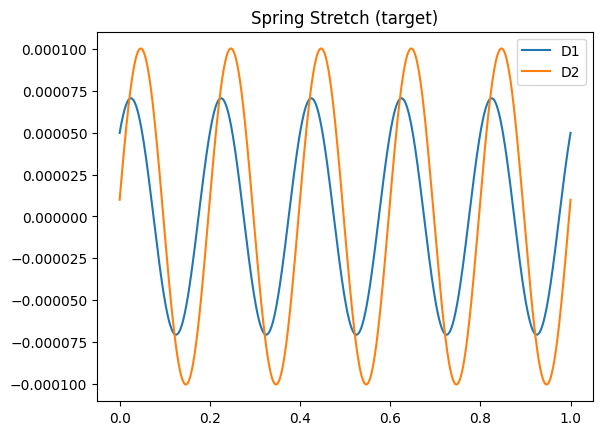

In [3]:
#
freq = np.array([5])
d1 = np.array([[.5], [1.]]) * 1E-4
d2 = np.array([[.5], [.1]]) * 1E-4
#
D1, D2 = [], []
for t in t_eval:
    D1.append(d1[0] @ np.sin(2 * np.pi * t * freq) + d2[0] @ np.cos(2 * np.pi * t * freq))
    D2.append(d1[1] @ np.sin(2 * np.pi * t * freq) + d2[1] @ np.cos(2 * np.pi * t * freq))
D1 = np.array(D1)
D2 = np.array(D2)
plt.figure()
plt.title('Spring Stretch (target)')
plt.plot(t_eval, D1, label='D1')
plt.plot(t_eval, D2, label='D2')
plt.legend()
plt.show()

In [4]:

#
lr = 1E3
Epoch = 1000
#
VOL1 = np.zeros((Epoch, vol1.shape[0], vol1.shape[1]))
VOL2 = np.zeros((Epoch, vol2.shape[0], vol2.shape[1]))
for e in tqdm.tqdm(range(Epoch)):
    #
    V1, V2 = [], []
    for t in t_eval:
        V1.append(vol1[0] @ np.sin(2 * np.pi * t * freq) + vol2[0] @ np.cos(2 * np.pi * t * freq))
        V2.append(vol1[1] @ np.sin(2 * np.pi * t * freq) + vol2[1] @ np.cos(2 * np.pi * t * freq))
    V1 = np.array(V1)
    V2 = np.array(V2)
    #
    # Solve the system of ODEs
    sol = solve_ivp(
        damped_coupled_oscillators,
        t_span,
        initial_conditions,
        args=(k1, k2, b1, b2, m1, m2, vol1, vol2, freq),
        t_eval=t_eval,
        method='RK45'  # Default method, but others like 'RK23', 'DOP853', 'BDF' can be used
    )
    # Calculate the stretch 
    S1 = sol.y[0]
    S2 = sol.y[2] - sol.y[0]
    #
    Q1_free = S1*Gamma + V1*Cap 
    Q2_free = S2*Gamma + V2*Cap
    #
    Q1_clamp = D1*Gamma + V1*Cap
    Q2_clamp = D2*Gamma + V2*Cap
    #
    N = len(t_eval)//2
    for n, fq in enumerate(freq):
        Q1_free_sin = 2*Q1_free[N:]@np.sin(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        Q1_free_cos = 2*Q1_free[N:]@np.cos(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        Q2_free_sin = 2*Q2_free[N:]@np.sin(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        Q2_free_cos = 2*Q2_free[N:]@np.cos(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        #
        Q1_clamp_sin = 2*Q1_clamp[N:]@np.sin(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        Q1_clamp_cos = 2*Q1_clamp[N:]@np.cos(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        Q2_clamp_sin = 2*Q2_clamp[N:]@np.sin(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        Q2_clamp_cos = 2*Q2_clamp[N:]@np.cos(2*np.pi*t_eval[N:]*fq)/len(t_eval[N:])
        #
        vol1[:, n] += np.array([Q1_clamp_sin-Q1_free_sin, Q2_clamp_sin-Q2_free_sin])*lr
        vol2[:, n] += np.array([Q1_clamp_cos-Q1_free_cos, Q2_clamp_cos-Q2_free_cos])*lr
        #
    VOL1[e] = vol1
    VOL2[e] = vol2


100%|██████████| 1000/1000 [01:53<00:00,  8.82it/s]


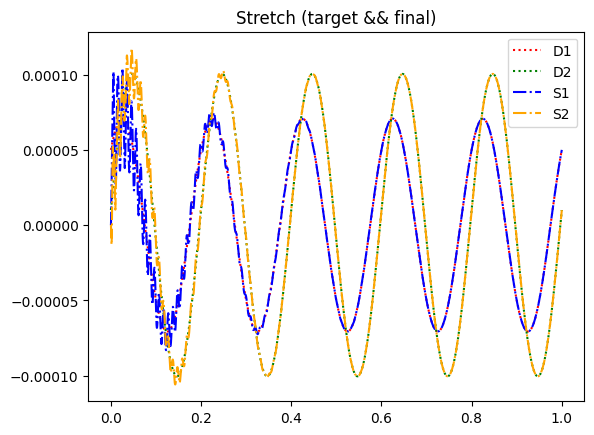

In [5]:
plt.figure()
plt.title('Stretch (target && final)')
plt.plot(t_eval, D1, label='D1', ls=':', c='r')
plt.plot(t_eval, D2, label='D2', ls=':', c='green')
plt.plot(t_eval, S1, label='S1', ls='-.', c='blue')
plt.plot(t_eval, S2, label='S2', ls='-.', c='orange')
plt.legend()
plt.show()